# PSIR and MP2RAGE T1-weighted Image Reconstruction

Based on Mougin et al. (2016) *Magnetic Resonance in Medicine* 76:1512-1516

**Imaging gray matter with concomitant null point imaging from the phase sensitive inversion recovery sequence**

In [1]:
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

## 1. Load Input Data

In [2]:
# Input files
ti1_mag = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_t787.nii.gz"
ti2_mag = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_t2387.nii.gz"
ti1_phase = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_ph_t787.nii.gz"
ti2_phase = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_ph_t2387.nii.gz"

# Output directory
output_dir = os.path.dirname(ti1_mag)

print("Loading data...")
# Load magnitude images
ti1_mag_img = nib.load(ti1_mag)
ti2_mag_img = nib.load(ti2_mag)
SI1 = ti1_mag_img.get_fdata()
SI2 = ti2_mag_img.get_fdata()

# Load phase images
ti1_phase_img = nib.load(ti1_phase)
ti2_phase_img = nib.load(ti2_phase)
phase1 = ti1_phase_img.get_fdata()
phase2 = ti2_phase_img.get_fdata()

print(f"Data shape: {SI1.shape}")
print(f"TI1 = 787 ms")
print(f"TI2 = 2387 ms")
print(f"TI1 magnitude range: [{SI1.min():.2f}, {SI1.max():.2f}]")
print(f"TI2 magnitude range: [{SI2.min():.2f}, {SI2.max():.2f}]")

Loading data...
Data shape: (224, 224, 120)
TI1 = 787 ms
TI2 = 2387 ms
TI1 magnitude range: [0.00, 2469299.09]
TI2 magnitude range: [0.00, 2487738.17]


## 2. Visualize Raw Input Images (Figure 2a,b,d,e from paper)

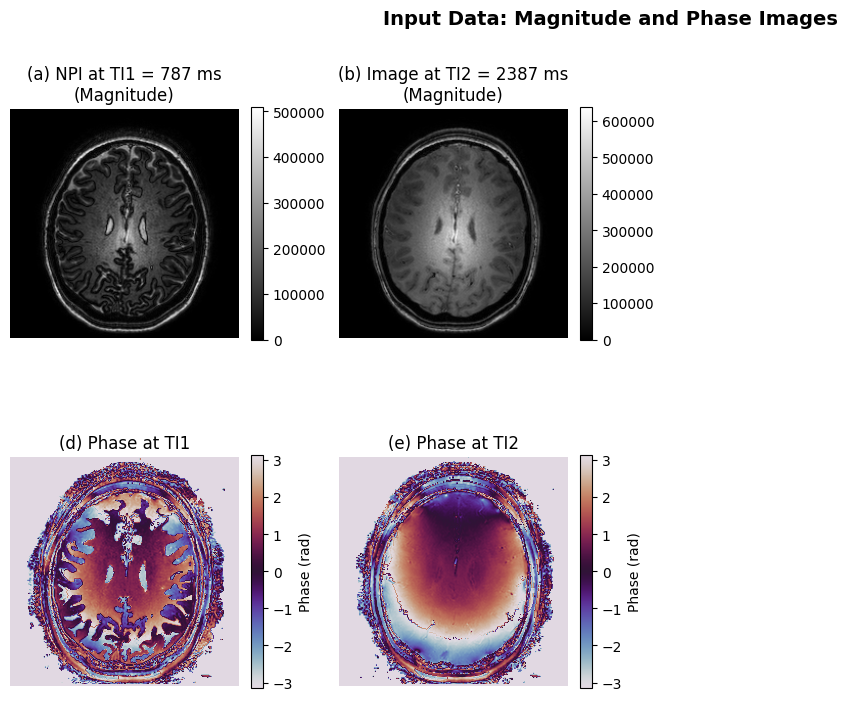

In [3]:
# Select middle slice for visualization
slice_idx = SI1.shape[2] // 2

fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 4, figure=fig, hspace=0.3, wspace=0.3)

# Row 1: Magnitude images
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(SI1[:, :, slice_idx].T, cmap='gray', origin='lower')
ax1.set_title('(a) NPI at TI1 = 787 ms\n(Magnitude)', fontsize=12)
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
ax2.set_title('(b) Image at TI2 = 2387 ms\n(Magnitude)', fontsize=12)
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046)

# Row 2: Phase images
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(phase1[:, :, slice_idx].T, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax4.set_title('(d) Phase at TI1', fontsize=12)
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046, label='Phase (rad)')

ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(phase2[:, :, slice_idx].T, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax5.set_title('(e) Phase at TI2', fontsize=12)
ax5.axis('off')
plt.colorbar(im5, ax=ax5, fraction=0.046, label='Phase (rad)')

plt.suptitle('Input Data: Magnitude and Phase Images', fontsize=14, fontweight='bold')
plt.show()

## 3. Create Brain Mask

Create a mask to avoid phase artifacts in noisy regions outside the brain.

Creating brain mask...
Mask covers 36.9% of volume


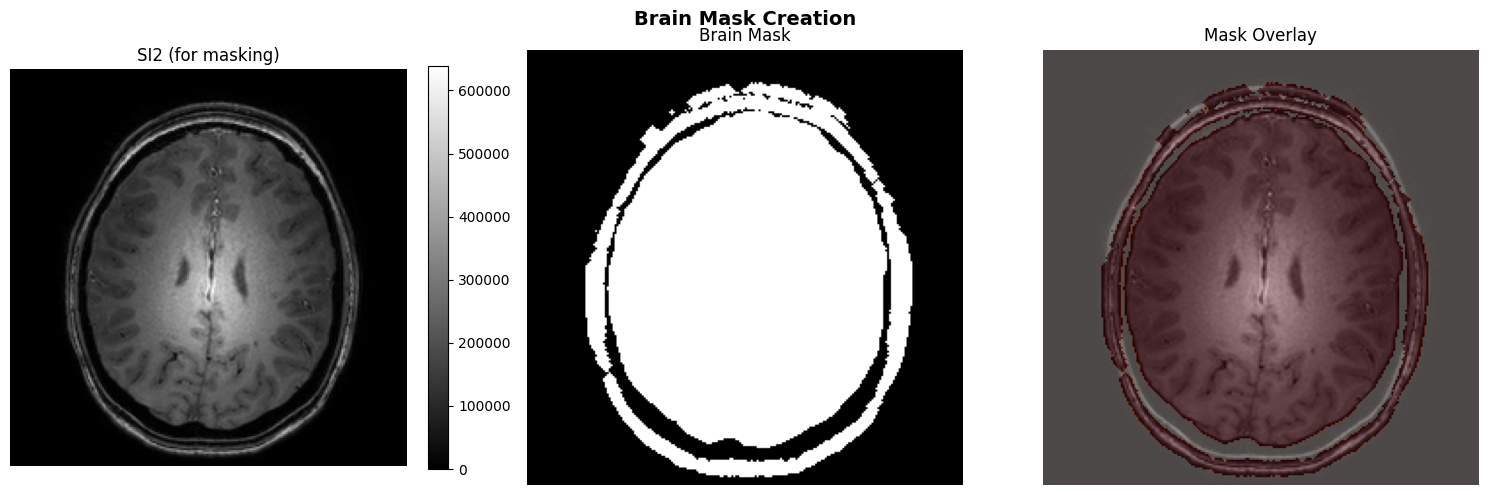

In [8]:
from scipy.ndimage import binary_erosion, binary_dilation

print("Creating brain mask...")
# Use SI2 (better SNR) to create mask
# Threshold at a percentage of max signal
threshold = 0.02 * SI2.max()
mask = SI2 > threshold

# Clean up mask with morphological operations
# Erode to remove noisy edges, then dilate back
mask = binary_erosion(mask, iterations=2)
mask = binary_dilation(mask, iterations=3)

print(f"Mask covers {100*mask.sum()/mask.size:.1f}% of volume")

# Visualize mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].set_title('SI2 (for masking)', fontsize=12)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(mask[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1].set_title('Brain Mask', fontsize=12)
axes[1].axis('off')

# Show mask overlay
axes[2].imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower', alpha=1.0)
axes[2].imshow(mask[:, :, slice_idx].T, cmap='Reds', origin='lower', alpha=0.3)
axes[2].set_title('Mask Overlay', fontsize=12)
axes[2].axis('off')

plt.suptitle('Brain Mask Creation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Polarity Restoration (Magnitude-Based)

Since phase at TI2 is uniform, we use magnitude-based polarity restoration instead.

At the null point (TI1), tissues with low signal relative to their recovered signal (SI2) 
likely had negative magnetization. We use the ratio SI1/SI2 to determine polarity.

The threshold is chosen based on the expected null point behavior:
- Voxels with SI1/SI2 < threshold had negative magnetization
- Voxels with SI1/SI2 > threshold had positive magnetization

Restoring polarity using magnitude-based method...
Polarity threshold (SI1/SI2): 0.4865
Voxels with negative polarity: 1110602 / 2221319
Percentage negative: 50.0%
Polarity restored SI1 range: [-376464.39, 2469299.09]


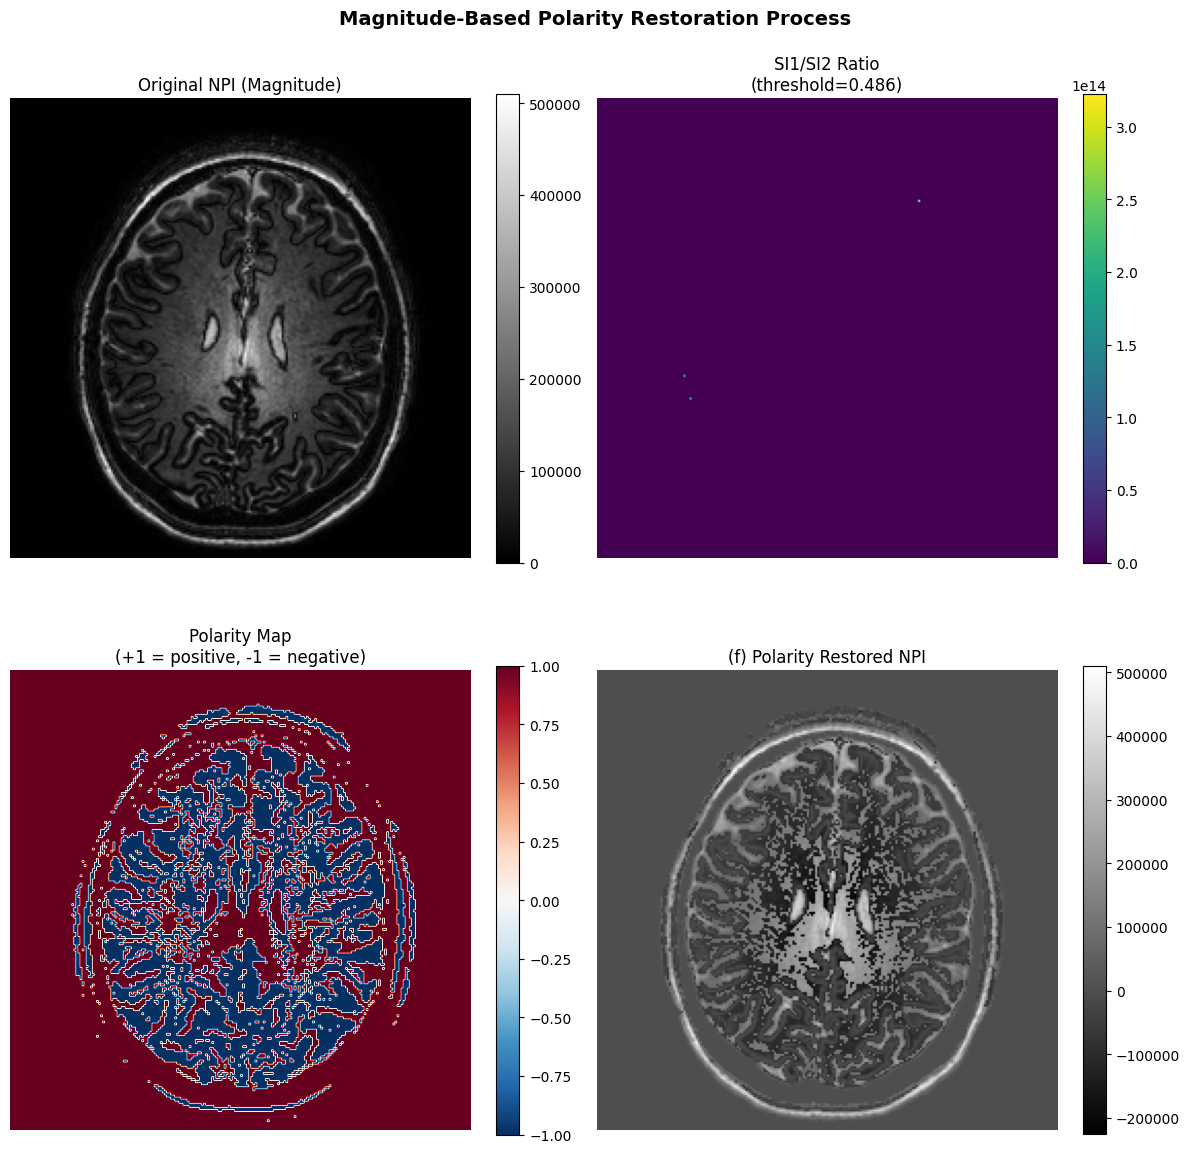

In [9]:
print("Restoring polarity using magnitude-based method...")

# Calculate ratio SI1/SI2 (only inside mask)
ratio = np.zeros_like(SI1)
ratio[mask] = SI1[mask] / (SI2[mask] + 1e-10)

# Determine threshold for polarity
# At null point, we expect a bimodal distribution
# Tissues near zero crossing will have low ratio
# We'll use median of the ratio as threshold
threshold = np.median(ratio[mask])
print(f"Polarity threshold (SI1/SI2): {threshold:.4f}")

# Create polarity map
# Low ratio (below threshold) → negative magnetization
# High ratio (above threshold) → positive magnetization  
polarity = np.ones_like(SI1)
polarity[mask & (ratio < threshold)] = -1

print(f"Voxels with negative polarity: {(polarity[mask] < 0).sum()} / {mask.sum()}")
print(f"Percentage negative: {100 * (polarity[mask] < 0).sum() / mask.sum():.1f}%")

# Apply polarity to SI1 ONLY inside the mask
SI1_polarity_restored = SI1.copy()
SI1_polarity_restored[mask] = SI1[mask] * polarity[mask]
SI1_polarity_restored[~mask] = 0

print(f"Polarity restored SI1 range: [{SI1_polarity_restored.min():.2f}, {SI1_polarity_restored.max():.2f}]")

# Visualize polarity restoration
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

im0 = axes[0, 0].imshow(SI1[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Original NPI (Magnitude)', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

im1 = axes[0, 1].imshow(ratio[:, :, slice_idx].T, cmap='viridis', origin='lower')
axes[0, 1].set_title(f'SI1/SI2 Ratio\n(threshold={threshold:.3f})', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

im2 = axes[1, 0].imshow(polarity[:, :, slice_idx].T, cmap='RdBu_r', origin='lower', vmin=-1, vmax=1)
axes[1, 0].set_title('Polarity Map\n(+1 = positive, -1 = negative)', fontsize=12)
axes[1, 0].axis('off')
plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)

im3 = axes[1, 1].imshow(SI1_polarity_restored[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1, 1].set_title('(f) Polarity Restored NPI', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

plt.suptitle('Magnitude-Based Polarity Restoration Process', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Create Normalization Image (for PSIR)

Add TI1 and TI2 magnitude images and smooth with 9×9×9 voxel Gaussian kernel.

Creating normalization image...
Smoothed normalization image range: [0.00, 803581.11]


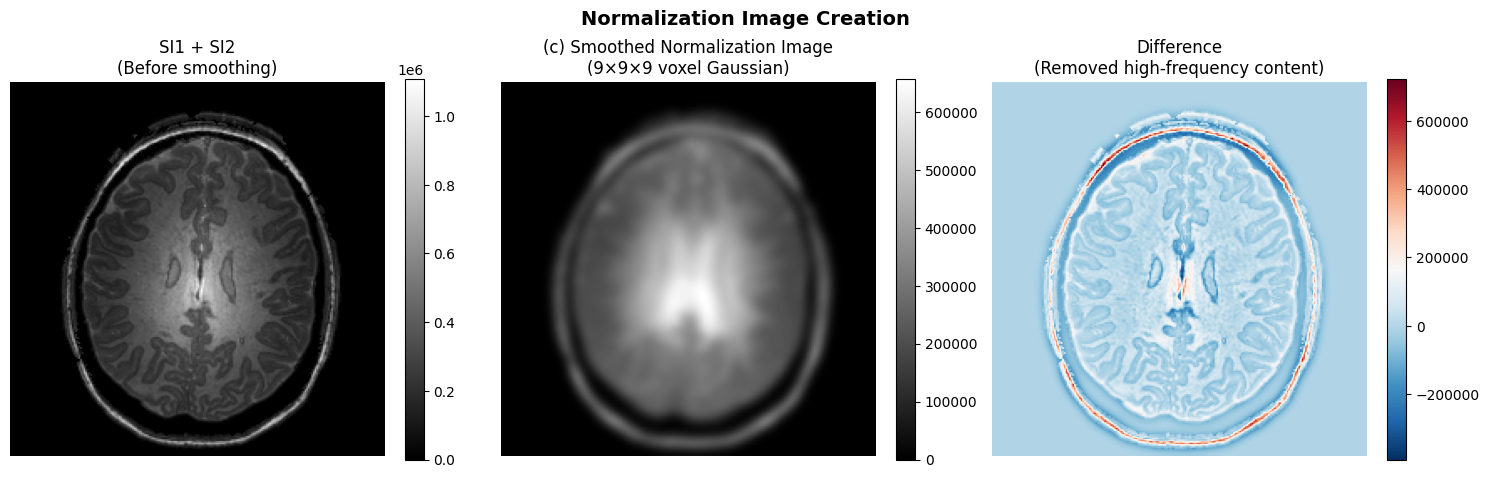

In [10]:
print("Creating normalization image...")
# Add magnitude images
sum_image = SI1 + SI2

# Apply mask to sum image
sum_image[~mask] = 0

# Smooth with Gaussian kernel (9x9x9 voxels as in paper)
# sigma ≈ 3 voxels gives approximately 9×9×9 voxel kernel
sigma_voxels = 3.0
smoothed_image = gaussian_filter(sum_image, sigma=sigma_voxels)

# Ensure smoothed image is never zero inside mask (avoid division by zero)
# Set a minimum threshold
min_threshold = 0.01 * smoothed_image[mask].max()
smoothed_image[mask & (smoothed_image < min_threshold)] = min_threshold

print(f"Smoothed normalization image range: [{smoothed_image.min():.2f}, {smoothed_image.max():.2f}]")

# Visualize normalization image creation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(sum_image[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].set_title('SI1 + SI2\n(Before smoothing)', fontsize=12)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(smoothed_image[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1].set_title('(c) Smoothed Normalization Image\n(9×9×9 voxel Gaussian)', fontsize=12)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Show difference to illustrate smoothing
diff = sum_image - smoothed_image
im2 = axes[2].imshow(diff[:, :, slice_idx].T, cmap='RdBu_r', origin='lower')
axes[2].set_title('Difference\n(Removed high-frequency content)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle('Normalization Image Creation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Create PSIR Image (Equation 1)

$$\text{PSIR} = \frac{\pm \text{SI1}}{\text{SI1} + \text{SI2}}$$

where ± indicates polarity restoration

Creating PSIR image...
PSIR range: [-5.09, 11.93]


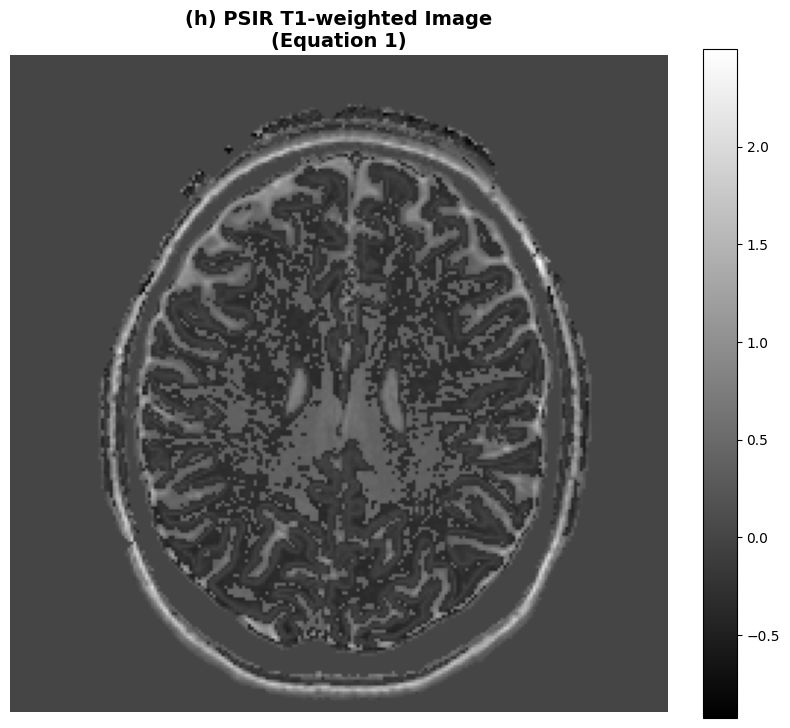

In [11]:
print("Creating PSIR image...")
# Avoid division by zero
epsilon = 1e-10
PSIR = SI1_polarity_restored / (smoothed_image + epsilon)

# Apply mask to final result
PSIR[~mask] = 0

print(f"PSIR range: [{PSIR.min():.2f}, {PSIR.max():.2f}]")

# Visualize PSIR
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(PSIR[:, :, slice_idx].T, cmap='gray', origin='lower')
ax.set_title('(h) PSIR T1-weighted Image\n(Equation 1)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

## 7. Create MP2RAGE Image (Simplified - Magnitude Only)

Since phase data is not reliable for this dataset, we use a simplified MP2RAGE:

$$\text{MP2RAGE} = \frac{\text{SI1} \cdot \text{SI2}}{\text{SI1}^2 + \text{SI2}^2}$$

This is similar to the original but without phase information.

Creating MP2RAGE image (magnitude-only version)...
MP2RAGE range: [-0.39, 0.50]


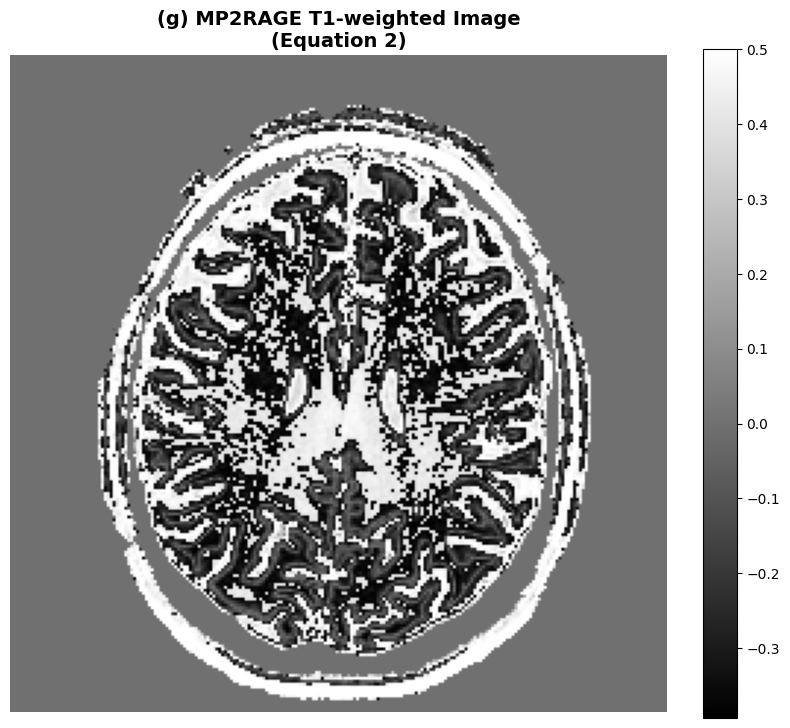

In [12]:
print("Creating MP2RAGE image (magnitude-only version)...")

# Simplified MP2RAGE without phase
# Use polarity-restored SI1 instead of complex multiplication
numerator = SI1_polarity_restored * SI2
denominator = SI1**2 + SI2**2
MP2RAGE = numerator / (denominator + epsilon)

# Apply mask to final result
MP2RAGE[~mask] = 0

print(f"MP2RAGE range: [{MP2RAGE.min():.2f}, {MP2RAGE.max():.2f}]")

# Visualize MP2RAGE
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower')
ax.set_title('(g) MP2RAGE T1-weighted Image\n(Equation 2)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

## 8. Compare All Reconstructions (Like Figure 2 in paper)

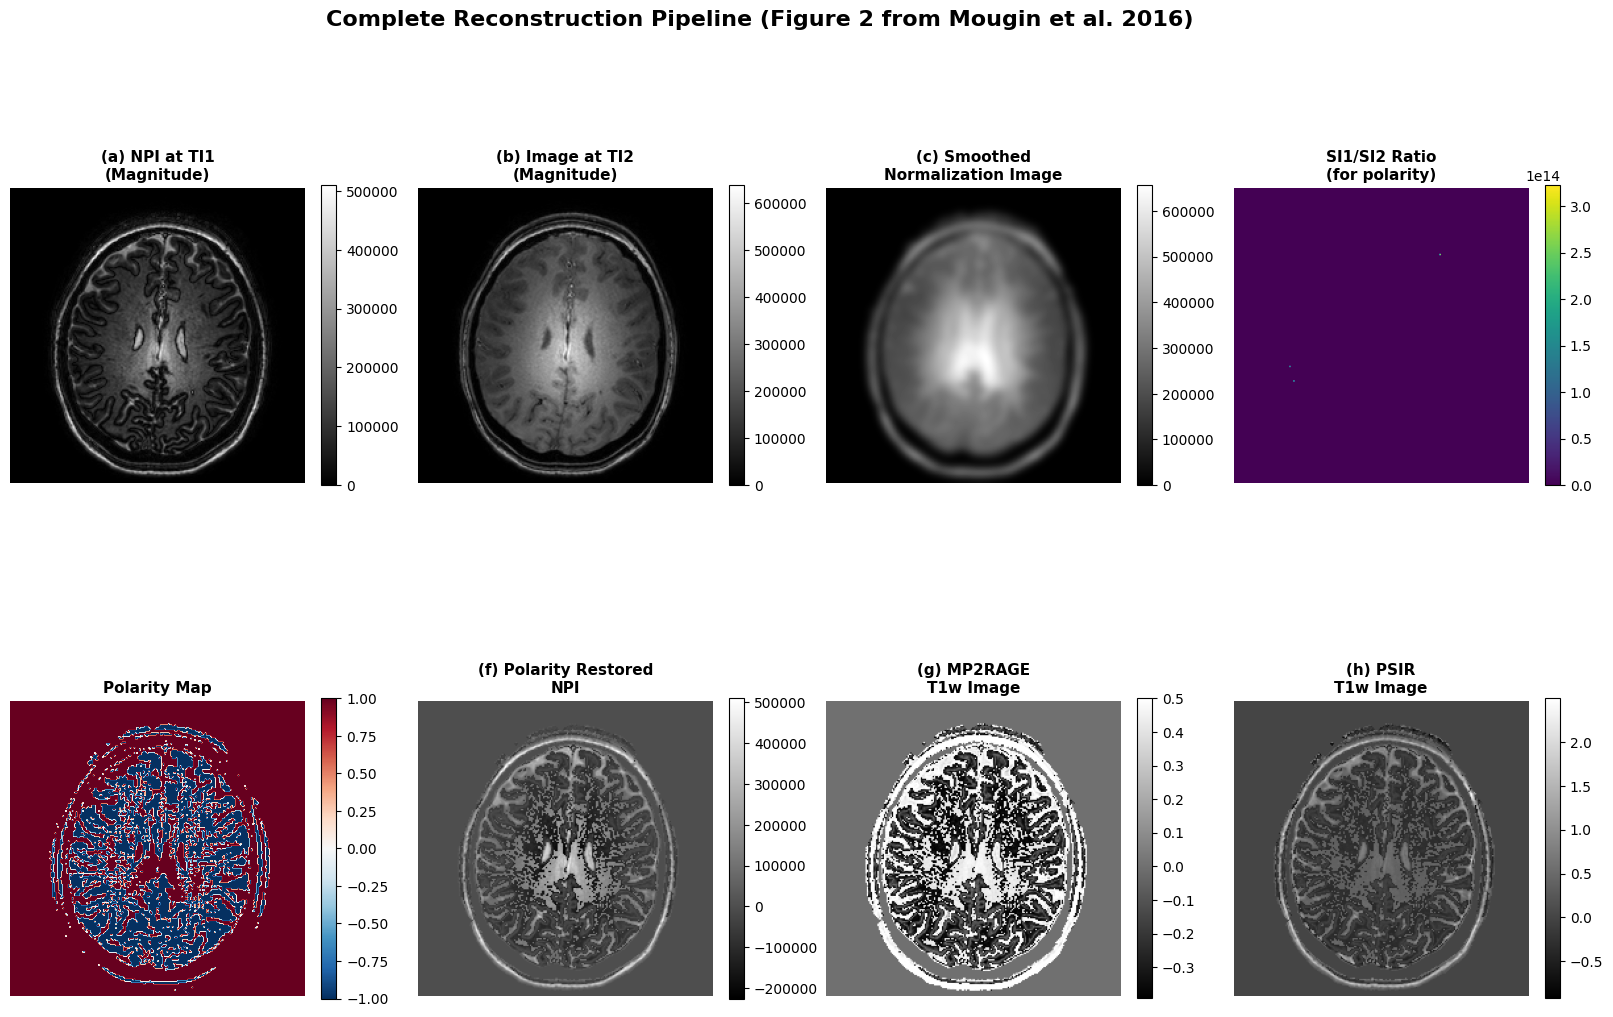

In [13]:
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(2, 4, figure=fig, hspace=0.25, wspace=0.25)

# Top row
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(SI1[:, :, slice_idx].T, cmap='gray', origin='lower')
ax1.set_title('(a) NPI at TI1\n(Magnitude)', fontsize=11, fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
ax2.set_title('(b) Image at TI2\n(Magnitude)', fontsize=11, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046)

ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(smoothed_image[:, :, slice_idx].T, cmap='gray', origin='lower')
ax3.set_title('(c) Smoothed\nNormalization Image', fontsize=11, fontweight='bold')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046)

ax4 = fig.add_subplot(gs[0, 3])
im4 = ax4.imshow(ratio[:, :, slice_idx].T, cmap='viridis', origin='lower')
ax4.set_title('SI1/SI2 Ratio\n(for polarity)', fontsize=11, fontweight='bold')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046)

# Bottom row
ax5 = fig.add_subplot(gs[1, 0])
im5 = ax5.imshow(polarity[:, :, slice_idx].T, cmap='RdBu_r', origin='lower', vmin=-1, vmax=1)
ax5.set_title('Polarity Map', fontsize=11, fontweight='bold')
ax5.axis('off')
plt.colorbar(im5, ax=ax5, fraction=0.046)

ax6 = fig.add_subplot(gs[1, 1])
im6 = ax6.imshow(SI1_polarity_restored[:, :, slice_idx].T, cmap='gray', origin='lower')
ax6.set_title('(f) Polarity Restored\nNPI', fontsize=11, fontweight='bold')
ax6.axis('off')
plt.colorbar(im6, ax=ax6, fraction=0.046)

ax7 = fig.add_subplot(gs[1, 2])
im7 = ax7.imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower')
ax7.set_title('(g) MP2RAGE\nT1w Image', fontsize=11, fontweight='bold')
ax7.axis('off')
plt.colorbar(im7, ax=ax7, fraction=0.046)

ax8 = fig.add_subplot(gs[1, 3])
im8 = ax8.imshow(PSIR[:, :, slice_idx].T, cmap='gray', origin='lower')
ax8.set_title('(h) PSIR\nT1w Image', fontsize=11, fontweight='bold')
ax8.axis('off')
plt.colorbar(im8, ax=ax8, fraction=0.046)

plt.suptitle('Complete Reconstruction Pipeline (Figure 2 from Mougin et al. 2016)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

## 9. Side-by-Side Comparison: PSIR vs MP2RAGE

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Use same window/level for fair comparison
vmin = min(PSIR.min(), MP2RAGE.min())
vmax = max(PSIR.max(), MP2RAGE.max())

im0 = axes[0].imshow(SI1_polarity_restored[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].set_title('Polarity Restored NPI\n(Raw TI1 data)', fontsize=13, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1].set_title('MP2RAGE Reconstruction\n(Equation 2)', fontsize=13, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(PSIR[:, :, slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2].set_title('PSIR Reconstruction\n(Equation 1 - Proposed)', fontsize=13, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle('Comparison of Reconstruction Methods (Equally Windowed)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Multi-slice Visualization

In [ ]:
# Show multiple slices
n_slices = 5
slice_indices = np.linspace(SI1.shape[2]//4, 3*SI1.shape[2]//4, n_slices, dtype=int)

fig, axes = plt.subplots(2, n_slices, figsize=(20, 8))

for i, slice_idx in enumerate(slice_indices):
    # Top row: PSIR
    axes[0, i].imshow(PSIR[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, i].set_title(f'PSIR\nSlice {slice_idx}', fontsize=10)
    axes[0, i].axis('off')
    
    # Bottom row: MP2RAGE
    axes[1, i].imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, i].set_title(f'MP2RAGE\nSlice {slice_idx}', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Multi-slice Comparison: PSIR (top) vs MP2RAGE (bottom)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Save Output Files

In [ ]:
print("Saving outputs...")

# Save PSIR
psir_img = nib.Nifti1Image(PSIR, ti1_mag_img.affine, ti1_mag_img.header)
psir_output = os.path.join(output_dir, "PARREC_WIPPSIR1mm3SENSE_20141016132749_15_PSIR.nii.gz")
nib.save(psir_img, psir_output)
print(f"✓ Saved PSIR: {psir_output}")

# Save MP2RAGE
mp2rage_img = nib.Nifti1Image(MP2RAGE, ti1_mag_img.affine, ti1_mag_img.header)
mp2rage_output = os.path.join(output_dir, "PARREC_WIPPSIR1mm3SENSE_20141016132749_15_MP2RAGE.nii.gz")
nib.save(mp2rage_img, mp2rage_output)
print(f"✓ Saved MP2RAGE: {mp2rage_output}")

# Save polarity-restored NPI (for reference)
npi_img = nib.Nifti1Image(SI1_polarity_restored, ti1_mag_img.affine, ti1_mag_img.header)
npi_output = os.path.join(output_dir, "PARREC_WIPPSIR1mm3SENSE_20141016132749_15_NPI_polarity_restored.nii.gz")
nib.save(npi_img, npi_output)
print(f"✓ Saved polarity-restored NPI: {npi_output}")

print("\n=== Done! ===")
print("\nNotes:")
print("- This implementation uses MAGNITUDE-BASED polarity restoration")
print("- The original paper used phase-based restoration, but your phase data was not suitable")
print("- The PSIR shows T1-weighted contrast with GM/WM differentiation")
print("- Results should be visually checked against your expected anatomy")
print("- You may need to adjust the polarity threshold if contrast looks inverted")

## Summary

This notebook implements a **magnitude-based PSIR reconstruction** adapted from:

> Mougin O, Abdel-Fahim R, Dineen R, Pitiot A, Evangelou N, Gowland P. **Imaging gray matter with concomitant null point imaging from the phase sensitive inversion recovery sequence**. *Magn Reson Med* 2016;76:1512-1516.

**Key modifications for this dataset:**
- TI1 = 787 ms creates a null point image (NPI) where GM and WM have similar signals
- TI2 = 2387 ms provides a fully recovered image for normalization
- **Magnitude-based polarity restoration** instead of phase-based (due to uniform phase at TI2)
- Brain masking to avoid artifacts from noisy regions outside the brain
- PSIR normalization (Eq. 1) provides good T1-weighted contrast

**Important notes:**
- This dataset's phase data was not suitable for the original phase-based polarity restoration
- The magnitude-based approach uses SI1/SI2 ratio to estimate which voxels crossed zero
- Results may differ from the paper's original method but should still provide useful T1w contrast